In [1]:
import pandas as pd 

df = pd.read_csv('UCI_Credit_Card.csv')

In [2]:
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


# Data Preprocessing and Exploring 

In [3]:
df['SEX'] = df['SEX'].map({1:'Male', 2:'Female'})

# Combine 0,5 and 6 into 4(that is others)

df['EDUCATION'] = df['EDUCATION'].replace({0:4, 5:4, 6:4})

# Combine 0 and 3 into 2(that is single)

df['MARRIAGE'] = df['MARRIAGE'].replace({0:2, 3:2})

<AxesSubplot:xlabel='Status', ylabel='COUNT'>

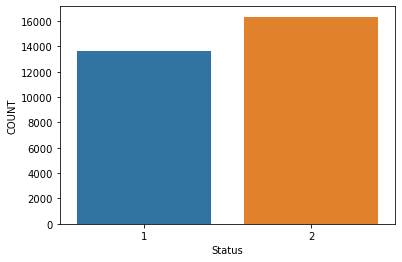

In [4]:
import seaborn as sns

mag_counts = df['MARRIAGE'].value_counts().reset_index()
mag_counts.columns = ['Status', 'COUNT']

sns.barplot(data=mag_counts, x='Status', y='COUNT')

<AxesSubplot:xlabel='SEX', ylabel='COUNT'>

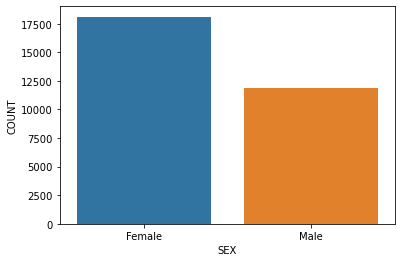

In [5]:
import seaborn as sns

sex_counts = df['SEX'].value_counts().reset_index()
sex_counts.columns = ['SEX', 'COUNT']

sns.barplot(data=sex_counts, x='SEX', y='COUNT')

In [6]:
df = pd.get_dummies(data= df, columns=['SEX'], drop_first=True)

In [7]:
df.rename(columns={'SEX_Male': 'Gender','PAY_0':'PAY_1'}, inplace=True)

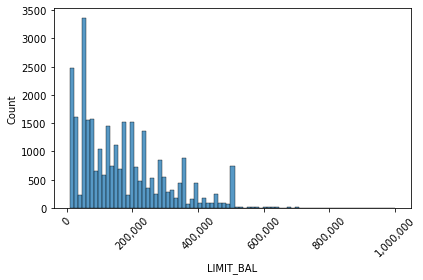

In [8]:
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
sns.histplot(data=df, x='LIMIT_BAL')


plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  
plt.xticks(rotation=45)  
plt.tight_layout()       
plt.show()


In [9]:
X = df.drop(columns=['default.payment.next.month', 'ID'])
y = df[['default.payment.next.month']]

In [10]:
X.shape, y.shape

((30000, 23), (30000, 1))

# XGBoost Model

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

/home/khatri.say/.local/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [19]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 300],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.3, 0.5],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0]
}

In [20]:
xgb_model = XGBClassifier()

In [21]:
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=10, scoring='roc_auc',
                                  n_jobs=-1, cv=5)

In [22]:
random_search.fit(X,y)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.3, 0.5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [100, 300]},
                   scoring='roc_auc')

In [27]:
print(random_search.best_estimator_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [29]:
xgb_model = XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None)

In [30]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(xgb_model, X,y, cv = 10)

In [32]:
score.mean()

0.8207000000000001

In [35]:
df = pd.get_dummies(data=df, columns=['EDUCATION', 'MARRIAGE'], drop_first=True)

In [42]:
df.columns

Index(['ID', 'LIMIT_BAL', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default.payment.next.month',
       'Gender', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'MARRIAGE_2'],
      dtype='object')

In [45]:
df = df.rename(columns={'EDUCATION_2':'Max_Education_University',
           'EDUCATION_3' : 'Max_Education_High_school',
           'EDUCATION_4' : 'Max_Education_Unknown',
           'MARRIAGE_2' : 'Marital_Status'
          })

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [52]:
X_train_scaled.shape[1]

23

# Neural Networks 

In [118]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

input_dim = X_train_scaled.shape[1]

model = Sequential(
    [
        Dense(16, activation='relu',input_dim = input_dim),
        Dropout(0.2),
        Dense(8, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ]

)

In [119]:
from tensorflow.keras.optimizers import Adam

adam = Adam(learning_rate=0.0001)

In [120]:
model.compile(optimizer=adam, loss='binary_crossentropy',
             metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

In [121]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(
    monitor='val_loss',
    patience = 3
)

history = model.fit(
    X_train_scaled, y_train,
    validation_split = 0.2,
    epochs = 70,
    batch_size = 8,
    verbose = 1,
    callbacks = [callback]

)

Epoch 1/70
600/600 [==============================] - 1s 1ms/step - loss: 0.6840 - accuracy: 0.5635 - auc: 0.5425 - val_loss: 0.6241 - val_accuracy: 0.7433 - val_auc: 0.5696
Epoch 2/70
600/600 [==============================] - 1s 923us/step - loss: 0.6084 - accuracy: 0.7210 - auc: 0.5508 - val_loss: 0.5798 - val_accuracy: 0.7733 - val_auc: 0.5789
Epoch 3/70
600/600 [==============================] - 1s 893us/step - loss: 0.5780 - accuracy: 0.7621 - auc: 0.5660 - val_loss: 0.5563 - val_accuracy: 0.7775 - val_auc: 0.5970
Epoch 4/70
600/600 [==============================] - 1s 865us/step - loss: 0.5588 - accuracy: 0.7804 - auc: 0.5803 - val_loss: 0.5415 - val_accuracy: 0.7800 - val_auc: 0.6136
Epoch 5/70
600/600 [==============================] - 1s 893us/step - loss: 0.5505 - accuracy: 0.7802 - auc: 0.5906 - val_loss: 0.5304 - val_accuracy: 0.7817 - val_auc: 0.6293
Epoch 6/70
600/600 [==============================] - 1s 891us/step - loss: 0.5368 - accuracy: 0.7925 - auc: 0.6016 - val_

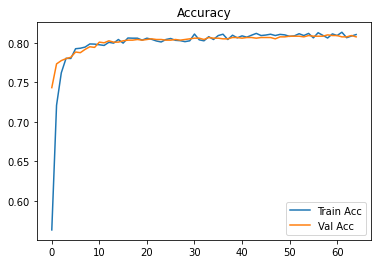

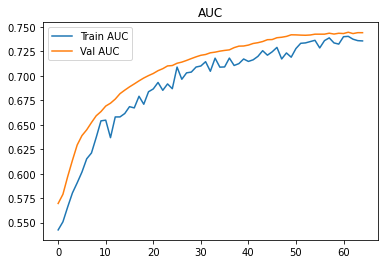

In [122]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

# AUC
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('AUC')
plt.legend()
plt.show()


# Logistic Regression 

In [147]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, classification_report, confusion_matrix 

In [148]:
lr = LogisticRegression(max_iter= 1000)

In [149]:
lr.fit(X_train_scaled,y_train)

/home/khatri.say/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=1000)

In [150]:
y_pred = lr.predict(X_test_scaled)

In [151]:
accuracy_score(y_pred, y_test)

0.8100416666666667

In [160]:
proba = lr.predict_proba(X_test_scaled)[:, 1]

threshold = 0.4
custom_preds = (proba >= threshold).astype(int)

print("Custom Threshold Report:\n", classification_report(y_test, custom_preds))


Custom Threshold Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89     18682
           1       0.65      0.38      0.48      5318

    accuracy                           0.82     24000
   macro avg       0.75      0.66      0.69     24000
weighted avg       0.80      0.82      0.80     24000

